In [ ]:
%load_ext autoreload
%autoreload 2

!pip3 install -I -r requirements.txt --quiet
!which python3
# Test hopsworks
try:
   import hopsworks
except ImportError:
   print()
   print("Hopsworks module not found!")

# Load the traning data
Done locally from `./titanic.csv`

In [1]:
import pandas as pd

titanic_df = pd.read_csv("./titanic.csv")

# drop ticket and passenger id columns
titanic_df.drop(["Ticket", "PassengerId"], axis=1, inplace=True)

# convert sex to category
titanic_df.Sex = pd.Categorical(titanic_df.Sex)
titanic_df["Sex"] = titanic_df.Sex.cat.codes

# Get overview of data

In [2]:
from IPython.core.interactiveshell import InteractiveShell

# Allow multiple outputs
InteractiveShell.ast_node_interactivity = "all"

### Check NaNs

In [ ]:
# Describe dataframe
titanic_df.describe()

# Check amount of NaNs
titanic_df.isnull().sum(axis = 0)

# Check NaNs in age
titanic_df.loc[titanic_df["Age"].isna()]

Take aways:

- Cabin has alot of NaNs, might need to drop
- Age has not as many NaNs, can resample them

### Check Name column

In [ ]:
titanic_df["Name"]

Take aways:

- Every name has a title
- Might be able to use to resample missing ages

### Check some gut feelings

In [ ]:
# titanic_df.loc[(titanic_df["Pclass"] == 3) & (titanic_df["Cabin"] == "G6")]
print("female survived")
len(titanic_df.loc[(titanic_df["Survived"] == 1) & (titanic_df["Sex"] == "female")])/len(titanic_df.loc[titanic_df["Sex"] == "female"])

print("child survived")
len(titanic_df.loc[(titanic_df["Survived"] == 1) & (titanic_df["Age"] <= 8 )])/len(titanic_df.loc[titanic_df["Age"] <= 8])

print("male survived")
len(titanic_df.loc[(titanic_df["Survived"] == 1) & (titanic_df["Sex"] == "male")])/len(titanic_df.loc[(titanic_df["Sex"] == "male")])


### Plot survival distributions based on features

In [ ]:
import seaborn as sns
# distribution of survival based on age
survived = titanic_df["Survived"] == 1

# fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))

# distribution of age
sns.histplot(titanic_df['Age'], label="Age", color="blue",)

sns.histplot(titanic_df[~survived]['Age'], label="Not Survived", color="red")
sns.histplot(titanic_df[survived]['Age'], label="Survived", color="green")


### Correlation Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

f, ax = plt.subplots(figsize=(10, 8))
corr = titanic_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

Take aways:

- Might be able to create a better feature for family on board

# Feature engineering

### Replace Name with corresponding title

In [3]:
if "Name" in titanic_df.columns:
    titanic_df["Title"] = titanic_df.Name.str.extract("([A-Za-z]+)\\.")
    titanic_df.drop("Name", axis=1, inplace=True)
titanic_df["Title"].unique()
titanic_df.head()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,NaN,S,Mr
1,1,1,0,38.0,1,0,71.2833,C85,C,Mrs
2,1,3,0,26.0,0,0,7.9250,NaN,S,Miss
3,1,1,0,35.0,1,0,53.1000,C123,S,Mrs
4,0,3,1,35.0,0,0,8.0500,NaN,S,Mr


### Replace missing ages based on title

In [4]:
import numpy as np
np.random.seed(seed=1337)

for title in titanic_df["Title"].unique():

    mask = (titanic_df["Title"] == title) & titanic_df["Age"].isna()

    # Get sutible candidates for age sampling
    candidates = titanic_df.loc[(titanic_df["Title"] == title) & titanic_df["Age"].notna()]

    g = candidates.groupby("Age", dropna=True)["Age"].count()
    g = g.apply(lambda x: x/g.sum())

    weights = g.to_numpy()
    ages = g.index

    titanic_df.update(titanic_df["Age"][mask].apply(lambda x: np.random.choice(ages, p=weights)))

All NaNs are now gone from the Age feature, mean of age shifted from `29.699118` to `29.707733`

Drawback, only using already existing ages

### Combining `SibSp` and `Parch` to one feature

In [5]:
titanic_df["Fmbrs"] =  titanic_df['SibSp'] + titanic_df['Parch']
titanic_df.drop(['Parch', 'SibSp'], axis=1 , inplace = True)
titanic_df.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Fmbrs
0,0,3,1,22.0,7.2500,NaN,S,Mr,1
1,1,1,0,38.0,71.2833,C85,C,Mrs,1
2,1,3,0,26.0,7.9250,NaN,S,Miss,0
3,1,1,0,35.0,53.1000,C123,S,Mrs,1
4,0,3,1,35.0,8.0500,NaN,S,Mr,0


In [6]:
titanic_df["Fmbrs"].describe()

count    891.000000
mean       0.904602
std        1.613459
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: Fmbrs, dtype: float64

### New correlation matrix

/var/folders/qm/htpqrf1j3y9_vkckvn_txydm0000gn/T/ipykernel_18458/2139103124.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = titanic_df.corr()
/var/folders/qm/htpqrf1j3y9_vkckvn_txydm0000gn/T/ipykernel_18458/2139103124.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


<AxesSubplot: >

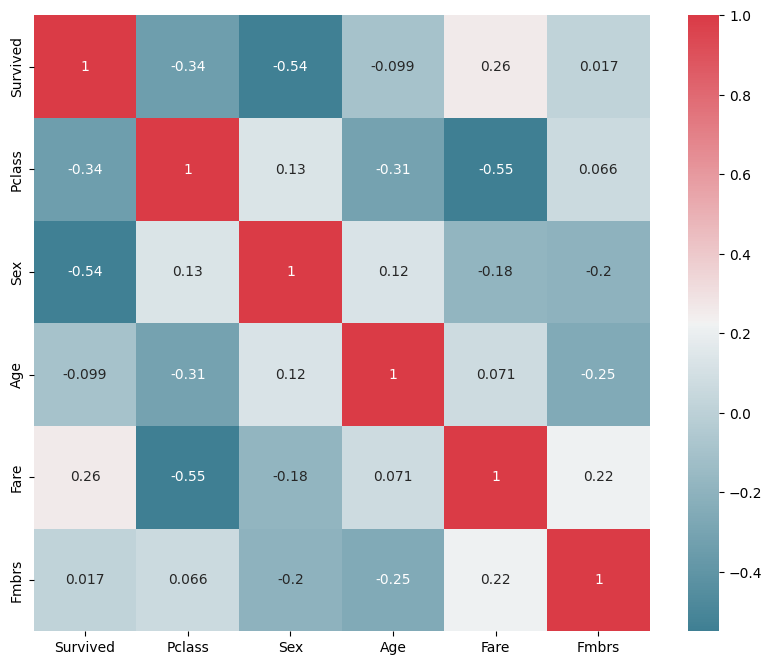

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

f, ax = plt.subplots(figsize=(10, 8))
corr = titanic_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

In [ ]:
import os
    
LOCAL=True

if LOCAL == False:
   stub = modal.Stub()
   image = modal.Image.debian_slim().pip_install(["hopsworks","joblib","seaborn","sklearn","dataframe-image"]) 

   @stub.function(image=image, schedule=modal.Period(days=1), secret=modal.Secret.from_name("jim-hopsworks-ai"))
   def f():
       g()

def g():
    import hopsworks
    import pandas as pd
    
    project = hopsworks.login()
    fs = project.get_feature_store()
    # iris_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/iris.csv")
    titanic_df = pd.read_csv("./titanic.csv")
    titanic_fg = fs.get_or_create_feature_group(
        name="iris_modal",
        version=1,
        primary_key=["sepal_length","sepal_width","petal_length","petal_width"], 
        description="Iris flower dataset")
    titanic_fg.insert(titanic_df, write_options={"wait_for_job" : False})

if __name__ == "__main__":
    if LOCAL == True :
        g()
    else:
        with stub.run():
            f()
